# Introduction

In this notebook, we will train an initial machine learning model to predict accident risks based on various features in our dataset. We will preprocess the data, select relevant features, and evaluate the model's performance.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings

from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# Load dataset

In [3]:
df = pd.read_csv('../data/processed/train.csv')

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

display(df.head())
print(df.info())

Dataset has 517754 rows and 14 columns.


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [4]:
# set data types for the columns

# set bool columns to int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  int64  
 8   public_road             517754 non-null  int64  
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  int64  
 11  school_season           517754 non-null  int64  
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: float64(2), int64

In [5]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

print(f"Numerical columns: {num_cols.tolist()}")
print(f"Categorical columns: {cat_cols.tolist()}")

Numerical columns: ['id', 'num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']
Categorical columns: ['road_type', 'lighting', 'weather', 'time_of_day']


# Prepare dataset for modeling

## Base Learner dataset preparation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df.drop('accident_risk', axis=1)
y = df['accident_risk']

# preprocessing: scale numeric, onehot encode categorical.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

In [7]:
# Train test split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# export train dataset
X_train.to_csv('../data/processed/X_train.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)

# export test dataset
X_val.to_csv('../data/processed/X_val.csv', index=False)
y_val.to_csv('../data/processed/y_val.csv', index=False)

# TabM model

In [12]:
# import torch
# from tabm import TabM
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from torch.utils.data import TensorDataset, DataLoader, random_split
# import numpy as np
#
# # ─── 1. Prepare the dataset ─────────────────────────────
# num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
# cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
# bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
#
# # Convert bool to int (0/1)
# df[bool_cols] = df[bool_cols].astype(int)
#
# # Encode categoricals to integer indices (0 .. nunique-1)
# encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
# for col, le in encoders.items():
#     df[col] = le.transform(df[col])
#
# # Compute cardinalities for each categorical feature
# cat_cardinalities = [df[c].nunique() for c in cat_cols]
#
# # Combine all numeric + boolean columns for model’s numeric part
# X_num = df[num_cols + bool_cols].values
# y = df['accident_risk'].values.reshape(-1, 1)
#
# # Scale numeric and boolean features
# scaler = StandardScaler()
# X_num_scaled = scaler.fit_transform(X_num)
#
# # Extract encoded categorical features
# X_cat = df[cat_cols].values
#
# # ─── 2. Convert to Torch tensors ─────────────────────────
# device = "cuda" if torch.cuda.is_available() else "cpu"
#
# x_num = torch.tensor(X_num_scaled, dtype=torch.float32)
# x_cat = torch.tensor(X_cat, dtype=torch.int64)
# y_true = torch.tensor(y, dtype=torch.float32)
#
# # ─── 3. Create dataset and DataLoaders ───────────────────
# full_dataset = TensorDataset(x_num, x_cat, y_true)
# n_total = len(full_dataset)
# n_train = int(n_total * 0.9)
# n_val = n_total - n_train
# train_ds, val_ds = random_split(full_dataset, [n_train, n_val])
#
# BATCH_SIZE = 2048
# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
#
# # ─── 4. Build the model ──────────────────────────────────
# n_num_features = X_num.shape[1]
# d_out = 1
# EPOCHS = 10
#
# model = TabM.make(
#     n_num_features=n_num_features,
#     cat_cardinalities=cat_cardinalities,
#     d_out=d_out,
# ).to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = torch.nn.MSELoss()
#
# # ─── 5. Training loop with validation ─────────────────────
# for epoch in range(EPOCHS):
#     model.train()
#     total_train_loss = 0.0
#
#     for xb_num, xb_cat, yb in train_loader:
#         xb_num, xb_cat, yb = xb_num.to(device), xb_cat.to(device), yb.to(device)
#         optimizer.zero_grad()
#
#         y_pred = model(xb_num, xb_cat).mean(1)
#         loss = criterion(y_pred, yb)
#         loss.backward()
#         optimizer.step()
#
#         total_train_loss += loss.item() * xb_num.size(0)
#
#     avg_train_loss = total_train_loss / n_train
#
#     # Validation pass
#     model.eval()
#     total_val_loss = 0.0
#     with torch.no_grad():
#         for xb_num, xb_cat, yb in val_loader:
#             xb_num, xb_cat, yb = xb_num.to(device), xb_cat.to(device), yb.to(device)
#             y_pred = model(xb_num, xb_cat).mean(1)
#             loss = criterion(y_pred, yb)
#             total_val_loss += loss.item() * xb_num.size(0)
#
#     avg_val_loss = total_val_loss / n_val
#     print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [10]:
import torch
import joblib
from tabm import TabM
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ─── Load preprocessing artifacts ───────────────────────────
encoders = joblib.load("../models/TabM/encoders.pkl")
scaler = joblib.load("../models/TabM/scaler.pkl")

# ─── Define feature groups ──────────────────────────────────
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']

Using device: cpu


In [11]:
# Example: load validation or test data
X_new = pd.read_csv('../data/processed/X_val.csv')
y_new = pd.read_csv('../data/processed/y_val.csv')

# Convert bools to int
X_new[bool_cols] = X_new[bool_cols].astype(int)

# Apply saved encoders
for col, le in encoders.items():
    # If unseen categories appear → replace with -1 (safe default)
    X_new[col] = X_new[col].map(lambda x: x if x in le.classes_ else -1)
    try:
        X_new[col] = le.transform(X_new[col])
    except ValueError:
        # Expand encoder classes if new values were replaced by -1
        le_classes = np.append(le.classes_, -1)
        le.classes_ = le_classes
        X_new[col] = le.transform(X_new[col])

# Apply saved scaler
X_num_scaled = scaler.transform(X_new[num_cols + bool_cols])
X_cat = X_new[cat_cols].values
y_true = y_new.values.flatten()

In [12]:
cat_cardinalities = [len(encoders[c].classes_) for c in cat_cols]
n_num_features = len(num_cols + bool_cols)

model = TabM.make(
    n_num_features=n_num_features,
    cat_cardinalities=cat_cardinalities,
    d_out=1
).to(device)

model.load_state_dict(torch.load(
    "../models/TabM/tabm_model.pt",
    map_location=device
))
model.eval()
print("Model and preprocessing restored.")

Model and preprocessing restored.


In [13]:
# Convert to tensors
x_num_t = torch.tensor(X_num_scaled, dtype=torch.float32).to(device)
x_cat_t = torch.tensor(X_cat, dtype=torch.int64).to(device)

# Predict in batches
loader = DataLoader(TensorDataset(x_num_t, x_cat_t), batch_size=2048, shuffle=False)
preds = []

with torch.no_grad():
    for xb_num, xb_cat in loader:
        y_pred = model(xb_num, xb_cat).mean(1).squeeze(1)
        preds.append(y_pred.cpu().numpy())

y_pred_np = np.concatenate(preds)

In [14]:
residuals = y_true - y_pred_np
rmse = np.sqrt(mean_squared_error(y_true, y_pred_np))
r2 = r2_score(y_true, y_pred_np)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print("\nResiduals sample:", residuals[:10])

# Save predictions
pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred_np,
    "residual": residuals
}).to_csv("../models/TabM/results/results.csv", index=False)

RMSE: 0.0573
R²: 0.8811

Residuals sample: [ 0.02439165 -0.12866055  0.02958141 -0.03794879  0.00517518  0.01258502
  0.09260381 -0.01627598 -0.07913748  0.00399821]


## Evaluation

In [15]:
import pandas as pd
import numpy as np

# ensure y_true and y_pred_np exist
df_compare = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred_np,
    "residual": y_true - y_pred_np
})

# compute absolute error to sort by closeness
df_compare["abs_residual"] = df_compare["residual"].abs()

# show summary
print("Mean residual:", df_compare["residual"].mean())
print("Residual std:", df_compare["residual"].std())
print("Mean absolute error:", df_compare['abs_residual'].mean())

print("\nClosest predictions (residuals ≈ 0):")
display(df_compare.nsmallest(10, "abs_residual"))

print("\nWorst predictions (largest residuals):")
display(df_compare.nlargest(10, "abs_residual"))

# save for external review
save_path = "../models/TabM/results/df_compare.csv"
df_compare.to_csv(save_path, index=False)
print(f"\ndf_compare saved to {save_path}")


Mean residual: 0.0037468375355353386
Residual std: 0.05717638539736854
Mean absolute error: 0.04450458381892914

Closest predictions (residuals ≈ 0):


,y_true,y_pred,residual,abs_residual
67837,0.11,0.110000,-2.452731e-07,2.452731e-07
61873,0.48,0.480000,-3.767014e-07,3.767014e-07
27146,0.16,0.160001,-6.818771e-07,6.818771e-07
33165,0.43,0.430002,-2.331734e-06,2.331734e-06
34988,0.09,0.089997,3.155470e-06,3.155470e-06
19994,0.07,0.069995,4.984140e-06,4.984140e-06
100570,0.19,0.189994,5.664825e-06,5.664825e-06
77721,0.22,0.219994,5.782843e-06,5.782843e-06
67435,0.34,0.339994,6.225109e-06,6.225109e-06
42984,0.31,0.309992,8.401871e-06,8.401871e-06



Worst predictions (largest residuals):


,y_true,y_pred,residual,abs_residual
34666,1.0,0.083670,0.916330,0.916330
41695,1.0,0.085851,0.914149,0.914149
18487,1.0,0.139550,0.860450,0.860450
81389,1.0,0.210935,0.789065,0.789065
77069,1.0,0.321952,0.678048,0.678048
40971,1.0,0.327800,0.672200,0.672200
39538,1.0,0.391650,0.608350,0.608350
75717,1.0,0.428952,0.571048,0.571048
60017,1.0,0.439153,0.560847,0.560847
99116,1.0,0.464948,0.535052,0.535052



df_compare saved to ../models/TabM/results/df_compare.csv


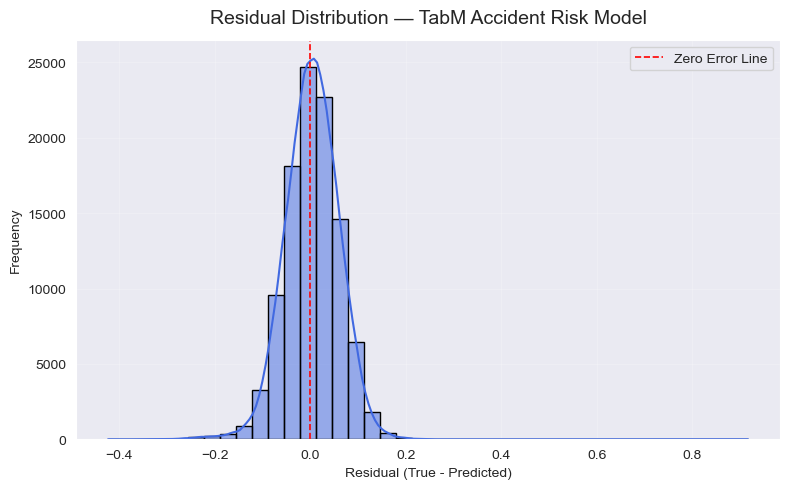

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_compare["residual"], bins=40, kde=True, color="royalblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", linewidth=1.2, label="Zero Error Line")
plt.title("Residual Distribution — TabM Accident Risk Model", fontsize=14, pad=12)
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# TabM modeling over residuals

In [17]:
# import torch
# import joblib
# from tabm import TabM
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error, r2_score
# from torch.utils.data import DataLoader, TensorDataset
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")
#
# # ─── Load preprocessing artifacts ───────────────────────────
# encoders = joblib.load("../models/TabM/encoders.pkl")
# scaler = joblib.load("../models/TabM/scaler.pkl")
#
# # ─── Define feature groups ──────────────────────────────────
# num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
# cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
# bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']

Using device: cpu


In [18]:
# # Example: load validation or test data
# X_new = pd.read_csv('../data/processed/X_val.csv')
# y_new = pd.read_csv('../data/processed/y_val.csv')
#
# # Convert bools to int
# X_new[bool_cols] = X_new[bool_cols].astype(int)
#
# # Apply saved encoders
# for col, le in encoders.items():
#     # If unseen categories appear → replace with -1 (safe default)
#     X_new[col] = X_new[col].map(lambda x: x if x in le.classes_ else -1)
#     try:
#         X_new[col] = le.transform(X_new[col])
#     except ValueError:
#         # Expand encoder classes if new values were replaced by -1
#         le_classes = np.append(le.classes_, -1)
#         le.classes_ = le_classes
#         X_new[col] = le.transform(X_new[col])
#
# # Apply saved scaler
# X_num_scaled = scaler.transform(X_new[num_cols + bool_cols])
# X_cat = X_new[cat_cols].values
# y_true = y_new.values.flatten()

In [19]:
# cat_cardinalities = [len(encoders[c].classes_) for c in cat_cols]
# n_num_features = len(num_cols + bool_cols)
#
# model = TabM.make(
#     n_num_features=n_num_features,
#     cat_cardinalities=cat_cardinalities,
#     d_out=1
# ).to(device)
#
# model.load_state_dict(torch.load(
#     "../models/TabM/tabm_residual.pt",
#     map_location=device
# ))
# model.eval()
# print("Model and preprocessing restored.")

Model and preprocessing restored.


In [20]:
# # Convert to tensors
# x_num_t = torch.tensor(X_num_scaled, dtype=torch.float32).to(device)
# x_cat_t = torch.tensor(X_cat, dtype=torch.int64).to(device)
#
# # Predict in batches
# loader = DataLoader(TensorDataset(x_num_t, x_cat_t), batch_size=2048, shuffle=False)
# preds = []
#
# with torch.no_grad():
#     for xb_num, xb_cat in loader:
#         y_pred = model(xb_num, xb_cat).mean(1).squeeze(1)
#         preds.append(y_pred.cpu().numpy())
#
# y_pred_np = np.concatenate(preds)

In [21]:
# residuals = y_true - y_pred_np
# rmse = np.sqrt(mean_squared_error(y_true, y_pred_np))
# r2 = r2_score(y_true, y_pred_np)
#
# print(f"RMSE: {rmse:.4f}")
# print(f"R²: {r2:.4f}")
# print("\nResiduals sample:", residuals[:10])
#
# # Save predictions
# pd.DataFrame({
#     "y_true": y_true,
#     "y_pred": y_pred_np,
#     "residual": residuals
# }).to_csv("../models/TabM/results/residual_results.csv", index=False)

RMSE: 0.3542
R²: -3.5443

Residuals sample: [0.37161913 0.1983533  0.36570396 0.30736991 0.33626237 0.35190164
 0.41110764 0.3267521  0.2660872  0.35081046]


## Evaluation

In [22]:
# import pandas as pd
# import numpy as np
#
# # ensure y_true and y_pred_np exist
# df_compare = pd.DataFrame({
#     "y_true": y_true,
#     "y_pred": y_pred_np,
#     "residual": y_true - y_pred_np
# })
#
# # compute absolute error to sort by closeness
# df_compare["abs_residual"] = df_compare["residual"].abs()
#
# # show summary
# print("Mean residual:", df_compare["residual"].mean())
# print("Residual std:", df_compare["residual"].std())
# print("Mean absolute error:", df_compare['abs_residual'].mean())
#
# print("\nClosest predictions (residuals ≈ 0):")
# display(df_compare.nsmallest(10, "abs_residual"))
#
# print("\nWorst predictions (largest residuals):")
# display(df_compare.nlargest(10, "abs_residual"))
#
# # save for external review
# save_path = "../models/TabM/results/residual_df_compare.csv"
# df_compare.to_csv(save_path, index=False)
# print(f"\ndf_compare saved to {save_path}")

Mean residual: 0.3494196622354225
Residual std: 0.05816972042037997
Mean absolute error: 0.3494228636380718

Closest predictions (residuals ≈ 0):


,y_true,y_pred,residual,abs_residual
82357,0.2,0.207686,-0.007686,0.007686
51590,0.1,0.109615,-0.009615,0.009615
82885,0.1,0.109997,-0.009997,0.009997
74362,0.1,0.089910,0.010090,0.010090
13714,0.1,0.110626,-0.010626,0.010626
33149,0.1,0.088745,0.011255,0.011255
22177,0.1,0.083087,0.016913,0.016913
5026,0.1,0.076763,0.023237,0.023237
3582,0.4,0.424264,-0.024264,0.024264
101674,0.2,0.174908,0.025092,0.025092



Worst predictions (largest residuals):


,y_true,y_pred,residual,abs_residual
34666,1.0,-0.266593,1.266593,1.266593
41695,1.0,-0.261092,1.261092,1.261092
18487,1.0,-0.200219,1.200219,1.200219
81389,1.0,-0.116082,1.116082,1.116082
77069,1.0,-0.010652,1.010652,1.010652
40971,1.0,0.008128,0.991872,0.991872
39538,1.0,0.057074,0.942926,0.942926
75717,1.0,0.072548,0.927452,0.927452
60017,1.0,0.100650,0.899350,0.899350
26715,1.0,0.104825,0.895175,0.895175



df_compare saved to ../models/TabM/results/residual_df_compare.csv


In [36]:
# import pandas as pd
#
# df_base  = pd.read_csv("../models/TabM/results/df_compare.csv")
# df_resid = pd.read_csv("../models/TabM/results/residual_df_compare.csv")
#
# # ensure order matches (they should — same dataset)
# df_compare = pd.DataFrame({
#     "y_true": df_base["y_true"],
#     "base_pred": df_base["y_pred"],
#     "resid_pred": df_resid["y_pred"],
#     "base_abs_resid": df_base["abs_residual"],
#     "resid_abs_resid": df_resid["abs_residual"]
# })
#
# # improvement delta
# df_compare["delta_abs_resid"] = df_compare["resid_abs_resid"] - df_compare["base_abs_resid"]
#
# # top 30 worst from base
# worst_base = df_compare.sort_values("base_abs_resid", ascending=False).head(500000)
#
# # flag improved/worse
# worst_base["improved"] = worst_base["resid_abs_resid"] < worst_base["base_abs_resid"]
#
# display(worst_base[[
#     "y_true", "base_pred", "resid_pred",
#     "base_abs_resid", "resid_abs_resid", "delta_abs_resid", "improved"
# ]])

,y_true,base_pred,resid_pred,base_abs_resid,resid_abs_resid,delta_abs_resid,improved
34666,1.00,0.083670,-0.266593,9.163301e-01,1.266593,0.350263,False
41695,1.00,0.085851,-0.261092,9.141493e-01,1.261092,0.346942,False
18487,1.00,0.139550,-0.200219,8.604502e-01,1.200219,0.339768,False
81389,1.00,0.210935,-0.116082,7.890650e-01,1.116082,0.327017,False
77069,1.00,0.321952,-0.010652,6.780477e-01,1.010652,0.332604,False
...,...,...,...,...,...,...,...
34988,0.09,0.089997,-0.270565,3.155470e-06,0.360565,0.360562,False
33165,0.43,0.430002,0.056633,2.331734e-06,0.373367,0.373365,False
27146,0.16,0.160001,-0.180634,6.818771e-07,0.340634,0.340633,False
61873,0.48,0.480000,0.117739,3.767014e-07,0.362261,0.362261,False


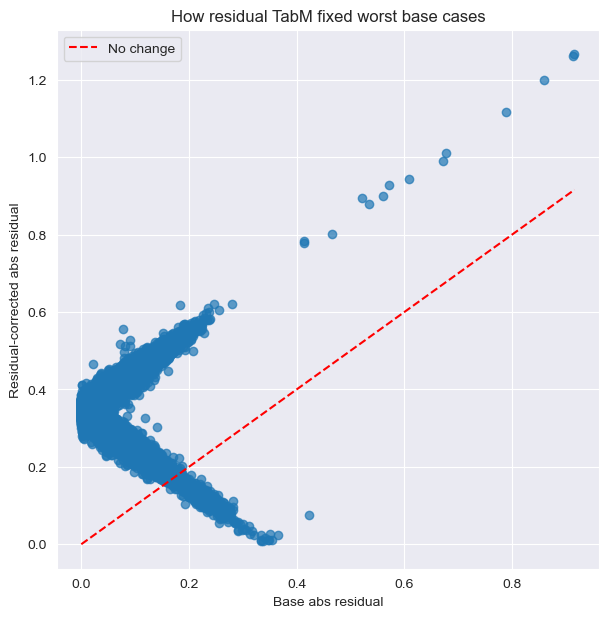

In [37]:
# import matplotlib.pyplot as plt
#
# plt.figure(figsize=(7,7))
# plt.scatter(worst_base["base_abs_resid"], worst_base["resid_abs_resid"], alpha=0.7)
# plt.plot([0, worst_base["base_abs_resid"].max()],
#          [0, worst_base["base_abs_resid"].max()], "r--", label="No change")
# plt.xlabel("Base abs residual")
# plt.ylabel("Residual-corrected abs residual")
# plt.title("How residual TabM fixed worst base cases")
# plt.legend()
# plt.show()


In [19]:
# improved = worst_base["improved"].sum()
# total = len(worst_base)
# print(f"{improved}/{total} of the worst base cases improved "
#       f"({improved/total:.1%}) after residual correction.")

In [42]:
# print("Mean abs residual (base):", df_compare["base_abs_resid"].mean())
# print("Mean abs residual (resid):", df_compare["resid_abs_resid"].mean())

Mean abs residual (base): 0.044504583818929105
Mean abs residual (resid): 0.34942286363807173


In [41]:
# df_test = df.copy()
# for col in ["road_type", "lighting", "weather", "time_of_day"]:
#     grp = df_test.merge(df_compare, left_index=True, right_index=True)
#     print(col)
#     print(
#         grp.groupby(col)[["base_abs_resid", "resid_abs_resid"]]
#         .mean()
#         .assign(delta=lambda d: d["resid_abs_resid"] - d["base_abs_resid"])
#         .sort_values("delta")
#     )

road_type
           base_abs_resid  resid_abs_resid     delta
road_type                                           
urban            0.044622         0.349314  0.304692
rural            0.044483         0.349322  0.304839
highway          0.044410         0.349631  0.305221
lighting
          base_abs_resid  resid_abs_resid     delta
lighting                                           
daylight        0.044459         0.349101  0.304641
night           0.044491         0.349397  0.304906
dim             0.044560         0.349756  0.305197
weather
         base_abs_resid  resid_abs_resid     delta
weather                                           
rainy          0.044548         0.349012  0.304464
foggy          0.044594         0.349315  0.304721
clear          0.044377         0.349887  0.305510
time_of_day
             base_abs_resid  resid_abs_resid     delta
time_of_day                                           
afternoon          0.044420         0.349159  0.304739
evening         

# XGBoost model

In [9]:
print(f"Numerical columns: {num_cols.tolist()}")
print(f"Categorical columns: {cat_cols.tolist()}")

if 'id' in num_cols:
    num_cols = num_cols.drop('id')
print()
print(f"Numerical columns after dropping 'id': {num_cols.tolist()}")

Numerical columns: ['id', 'num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']
Categorical columns: ['road_type', 'lighting', 'weather', 'time_of_day']

Numerical columns after dropping 'id': ['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']


In [10]:
# Preprocessor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

for col in num_cols:
    if col == 'accident_risk':
        num_cols = num_cols.drop(col)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [11]:
reg_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

## Cross validation

In [12]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', reg_xgb)
])

In [13]:
from sklearn.model_selection import train_test_split

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_tr.shape[0]} rows")
print(f"Validation set: {X_val.shape[0]} rows")

Training set: 331362 rows
Validation set: 82841 rows


In [14]:
# ─────────────────────────────────────────────────────────────────────────────
#  Accident Risk Prediction - XGBoost CV Training Script (OOF + ID)
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
import os

# ─── 1. Prepare data ─────────────────────────────────────────────
X = X_train.copy()
y = y_train.copy()

# If an ID column exists, separate it out (don’t train on it)
if "id" in X.columns:
    ids = X["id"].copy()
    X = X.drop(columns=["id"])
else:
    ids = np.arange(len(X))

# ─── 2. Cross-validation setup ─────────────────────────────────────────────
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores, r2_scores, mse_scores = [], [], []
y_pred_full = np.zeros(len(y))

y_array = np.array(y).flatten()

# ─── 3. Training loop ─────────────────────────────────────────────
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n──── Fold {fold} ──────────────────────────────────────")

    X_tr_f, X_val_f = X.iloc[train_idx], X.iloc[val_idx]
    y_tr_f, y_val_f = y_array[train_idx], y_array[val_idx]

    # Clone a fresh model each fold
    model_fold = clone(xgb_pipeline)

    model_fold.fit(X_tr_f, y_tr_f)

    # predict on validation fold
    y_pred = model_fold.predict(X_val_f)
    y_pred_full[val_idx] = y_pred

    # metrics
    mse = mean_squared_error(y_val_f, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_f, y_pred)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mse_scores.append(mse)

    print(f"  MSE={mse:.5f}  RMSE={rmse:.5f}  R²={r2:.5f}")

# ─── 4. Summary ─────────────────────────────────────────────
print("\n────────────── Summary ──────────────")
print(f"Mean MSE : {np.mean(mse_scores):.5f} ± {np.std(mse_scores):.5f}")
print(f"Mean RMSE: {np.sqrt(np.mean(mse_scores)):.5f}")
print(f"Mean R²  : {np.mean(r2_scores):.5f} ± {np.std(r2_scores):.5f}")


──── Fold 1 ──────────────────────────────────────
  MSE=0.00312  RMSE=0.05584  R²=0.88759

──── Fold 2 ──────────────────────────────────────
  MSE=0.00311  RMSE=0.05577  R²=0.88794

──── Fold 3 ──────────────────────────────────────
  MSE=0.00316  RMSE=0.05622  R²=0.88566

──── Fold 4 ──────────────────────────────────────
  MSE=0.00317  RMSE=0.05626  R²=0.88595

──── Fold 5 ──────────────────────────────────────
  MSE=0.00319  RMSE=0.05648  R²=0.88476

────────────── Summary ──────────────
Mean MSE : 0.00315 ± 0.00003
Mean RMSE: 0.05611
Mean R²  : 0.88638 ± 0.00120


In [15]:
# ─── 5. Save OOF predictions for stacking ─────────────────────────────
save_dir = "../models/XGB"
os.makedirs(save_dir, exist_ok=True)

df_oof_preds_xgb = pd.DataFrame({
    "id": ids,
    "y_true": y_array,
    "xgb_preds": y_pred_full
})
path = os.path.join(save_dir, "oof_preds_xgb.csv")
df_oof_preds_xgb.to_csv(path, index=False)
print(f"\n✅ Saved OOF predictions → {path}")



✅ Saved OOF predictions → ../models/XGB/oof_preds_xgb.csv


## Evaluate

In [16]:
import numpy as np

# residuals
y_residuals = np.ravel(y_array) - y_pred_full
mean_residual = np.mean(y_residuals)

rmse = np.sqrt(np.mean(y_residuals ** 2))

print(f"Mean residual: {mean_residual:.6f}")
print(f"RMSE: {rmse:.6f}")

Mean residual: -0.000003
RMSE: 0.056115


In [17]:
xgb_pipeline.fit(X_tr, y_tr)
y_val_pred = xgb_pipeline.predict(X_val)

y_val_resid = y_val.values.flatten() - y_val_pred
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²: {val_r2:.4f}")

Validation RMSE: 0.0558
Validation R²: 0.8876


## Save

In [18]:
import joblib

#train one final model on all data
final_model = clone(xgb_pipeline)
final_model.fit(X, y)
joblib.dump(final_model, "../models/XGB/reg_xgb.pkl")
print(f"Saved final model ../models/XGB/reg_xgb.pkl")

Saved final model ../models/XGB/reg_xgb.pkl


# LGBM model

In [127]:
# Preprocessor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

for col in num_cols:
    if col == 'accident_risk':
        num_cols = num_cols.drop(col)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [128]:
from lightgbm import LGBMRegressor

reg_lgbm = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1
)

In [129]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', reg_lgbm)
])

In [130]:
from sklearn.model_selection import train_test_split

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_tr.shape[0]} rows")
print(f"Validation set: {X_val.shape[0]} rows")

Training set: 331362 rows
Validation set: 82841 rows


## Cross validation

In [131]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

# set X and y
X = X_train.copy()
y = y_train.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# store results
rmse_scores, r2_scores, mse_scores = [], [], []
y_pred_full = np.zeros(len(y))

# convert y to numpy array for indexing
y_array = np.array(y)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold}")
    X_tr_f, X_val_f = X.iloc[train_idx], X.iloc[val_idx]
    y_tr_f, y_val_f = y_array[train_idx], y_array[val_idx]

    model_fold = clone(lgbm_pipeline)

    model_fold.fit(X_tr_f, y_tr_f)

    # predict on validation fold
    y_pred = model_fold.predict(X_val_f)
    y_pred_full[val_idx] = y_pred

    # metrics
    mse = mean_squared_error(y_val_f, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_f, y_pred)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"  MSE={mse:.5f}  RMSE={np.sqrt(mse):.5f}  R²={r2:.5f}")

print("\n────────────── Summary ──────────────")
print(f"Mean MSE: {np.mean(mse_scores):.5f} ± {np.std(mse_scores):.5f}")
print(f"Mean RMSE: {np.sqrt(np.mean(mse_scores)):.5f}")
print(f"Mean R²: {np.mean(r2_scores):.5f} ± {np.std(r2_scores):.5f}")

Fold 0
  MSE=0.00313  RMSE=0.05594  R²=0.88718
Fold 1
  MSE=0.00312  RMSE=0.05586  R²=0.88757
Fold 2
  MSE=0.00317  RMSE=0.05632  R²=0.88526
Fold 3
  MSE=0.00318  RMSE=0.05636  R²=0.88554
Fold 4
  MSE=0.00320  RMSE=0.05659  R²=0.88432

────────────── Summary ──────────────
Mean MSE: 0.00316 ± 0.00003
Mean RMSE: 0.05622
Mean R²: 0.88597 ± 0.00122


In [132]:
df_oof_preds_lgbm = pd.DataFrame({
    "y_true": np.ravel(y_array),
    "y_pred": np.ravel(y_pred_full)
}, index=np.arange(len(y_array)))
df_oof_preds_lgbm.to_csv('../models/lgbm/oof_preds_lgbm.csv', index=False)

## Evaluation

In [133]:
import numpy as np

# residuals
y_residuals = np.ravel(y_array) - y_pred_full
mean_residual = np.mean(y_residuals)

rmse = np.sqrt(np.mean(y_residuals ** 2))

print(f"Mean residual: {mean_residual:.6f}")
print(f"RMSE: {rmse:.6f}")

Mean residual: -0.000001
RMSE: 0.056216


In [134]:
lgbm_pipeline.fit(X_tr, y_tr)
y_val_pred = lgbm_pipeline.predict(X_val)

y_val_resid = y_val.values.flatten() - y_val_pred
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²: {val_r2:.4f}")

Validation RMSE: 0.0559
Validation R²: 0.8872


## Save

In [152]:
# ─── 5. Save OOF predictions for stacking ─────────────────────────────
save_dir = "../models/LGBM"
os.makedirs(save_dir, exist_ok=True)

df_oof_preds_lgbm = pd.DataFrame({
    "id": ids,
    "y_true": y_array.flatten(),
    "lgbm_preds": y_pred_full
})
path = os.path.join(save_dir, "oof_preds_lgbm.csv")
df_oof_preds_lgbm.to_csv(path, index=False)
print(f"\n✅ Saved OOF predictions → {path}")



✅ Saved OOF predictions → ../models/LGBM/oof_preds_lgbm.csv


# Pytorch Tabular

In [20]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

print(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414203 entries, 0 to 414202
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      414203 non-null  int64  
 1   road_type               414203 non-null  object 
 2   num_lanes               414203 non-null  int64  
 3   curvature               414203 non-null  float64
 4   speed_limit             414203 non-null  int64  
 5   lighting                414203 non-null  object 
 6   weather                 414203 non-null  object 
 7   road_signs_present      414203 non-null  int64  
 8   public_road             414203 non-null  int64  
 9   time_of_day             414203 non-null  object 
 10  holiday                 414203 non-null  int64  
 11  school_season           414203 non-null  int64  
 12  num_reported_accidents  414203 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 41.1+ MB
None


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,143159,rural,2,0.43,60,dim,clear,0,0,afternoon,1,1,2
1,20172,highway,4,0.18,25,night,clear,0,0,afternoon,1,0,1
2,57926,urban,1,0.20,70,night,clear,0,1,morning,1,1,1
3,193319,urban,3,0.81,60,daylight,foggy,1,0,evening,1,1,1
4,213938,rural,3,0.43,35,night,rainy,0,1,morning,1,1,2


In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_tr.shape[0]} rows")
print(f"Validation set: {X_val.shape[0]} rows")

Training set: 331362 rows
Validation set: 82841 rows


In [26]:
X_train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,143159,rural,2,0.43,60,dim,clear,0,0,afternoon,1,1,2
1,20172,highway,4,0.18,25,night,clear,0,0,afternoon,1,0,1
2,57926,urban,1,0.20,70,night,clear,0,1,morning,1,1,1
3,193319,urban,3,0.81,60,daylight,foggy,1,0,evening,1,1,1
4,213938,rural,3,0.43,35,night,rainy,0,1,morning,1,1,2


# Correlation check for OOF residuals

OOF XGB shape: (414203, 3)
OOF LGBM shape: (414203, 3)
OOF TabM shape: (414203, 3)
OOF Predictions Correlation Matrix:
              y_true  xgb_preds  lgbm_preds  tabm_preds
y_true      1.000000   0.941480    0.941263    0.939309
xgb_preds   0.941480   1.000000    0.999766    0.997706
lgbm_preds  0.941263   0.999766    1.000000    0.997791
tabm_preds  0.939309   0.997706    0.997791    1.000000


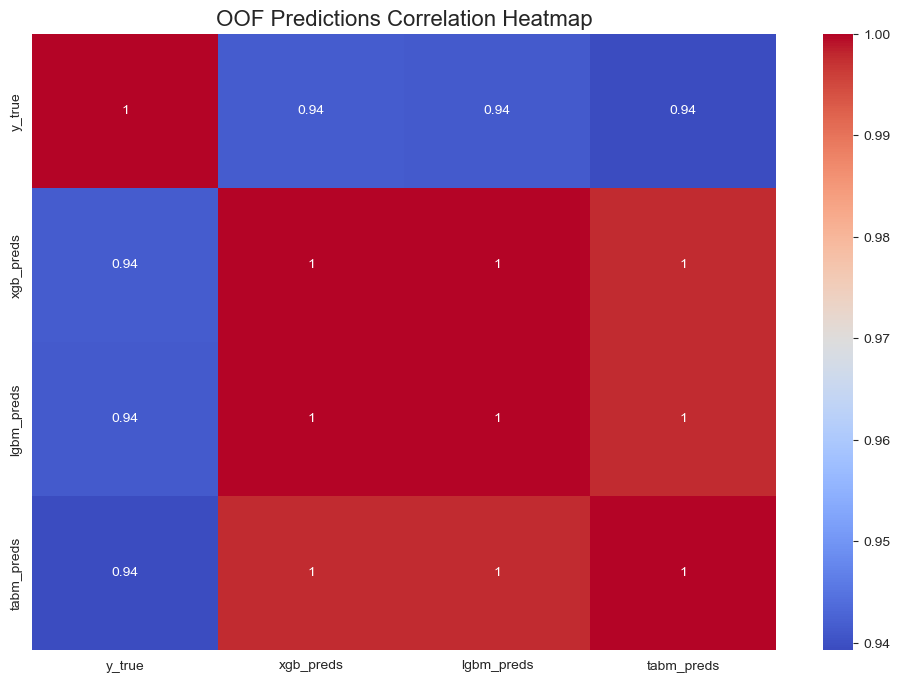

In [163]:
# load oof predictions
oof_xgb = pd.read_csv('../models/XGB/oof_preds_xgb.csv')
oof_lgbm = pd.read_csv('../models/LGBM/oof_preds_lgbm.csv')
oof_tabm = pd.read_csv('../models/TabM/oof_preds_tabm.csv')

print(f"OOF XGB shape: {oof_xgb.shape}")
print(f"OOF LGBM shape: {oof_lgbm.shape}")
print(f"OOF TabM shape: {oof_tabm.shape}")

# make a df with each model's oof predictions
oof_preds = pd.DataFrame({
    "y_true": oof_xgb["y_true"],
    "xgb_preds": oof_xgb["xgb_preds"],
    "lgbm_preds": oof_lgbm["lgbm_preds"],
    "tabm_preds": oof_tabm["tabm_preds"]
})

oof_corr = oof_preds.corr()
print("OOF Predictions Correlation Matrix:")
print(oof_corr)

plt.figure(figsize=(12, 8))
sns.heatmap(oof_corr, annot=True, cmap='coolwarm')
plt.title('OOF Predictions Correlation Heatmap', fontsize=16)
plt.show()

In [165]:
# Merge by ID first to align properly
merged = (
    oof_xgb[["id", "xgb_preds"]]
    .merge(oof_lgbm[["id", "lgbm_preds"]], on="id")
    .merge(oof_tabm[["id", "tabm_preds"]], on="id")
)

# Then compare
diff_count = (merged["lgbm_preds"] != merged["xgb_preds"]).sum()
print(f"Different predictions (aligned by id): {diff_count} / {len(merged)}")

# or use np.isclose to ignore float noise
diff_count_tol = (~np.isclose(merged["lgbm_preds"], merged["xgb_preds"], atol=1e-9)).sum()
print(f"Different predictions beyond tolerance: {diff_count_tol}")

Different predictions (aligned by id): 414203 / 414203
Different predictions beyond tolerance: 413691


In [171]:
merged_noid = merged.drop('id', axis=1)
oof_corr = merged.corr()
print("OOF Predictions Correlation Matrix:")
print(oof_corr)

OOF Predictions Correlation Matrix:
                  id  xgb_preds  lgbm_preds  tabm_preds
id          1.000000   0.002169    0.002203    0.002148
xgb_preds   0.002169   1.000000    0.999766    0.997706
lgbm_preds  0.002203   0.999766    1.000000    0.997791
tabm_preds  0.002148   0.997706    0.997791    1.000000
